# [Predictive Clinical Neuroscience Toolkit](https://github.com/amarquand/PCNtoolkit)
# The Normative Modeling Framework for Computational Psychiatry Protocol
## Using Bayesian Linear Regression and Multi-Site Cortical Thickness Data

Created by [Saige Rutherford](https://twitter.com/being_saige)

<div>
<img src="https://github.com/predictive-clinical-neuroscience/PCNtoolkit-demo/blob/main/tutorials/BLR_protocol/Figure2.png?raw=1" width="1000">
</div>

# Data Preparation

## Install necessary libraries & grab data files

In [180]:
# !sudo apt-get update -y
# !sudo apt-get install python3.9
# !sudo apt-get install python3.9-distutils
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 1
# !sudo update-alternatives --config python3
# !apt-get install python3-pip
# !python -m pip install --upgrade pip --user


Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://cli.github.com/packages stable InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

In [181]:
! git clone https://github.com/predictive-clinical-neuroscience/PCNtoolkit-demo.git

fatal: destination path 'PCNtoolkit-demo' already exists and is not an empty directory.


In [182]:
!python --version

Python 3.9.25


### Step 1.

Begin by cloning the GitHub repository using the following commands. This repository contains the necessary code and example data. Then install the python packages using pip and import them into the python environment (either Google Colab or using a local python installation on your computer).

In [183]:
import os

# set this path to the git cloned PCNtoolkit-demo repository --> Uncomment whichever line you need for either running on your own computer or on Google Colab.
#wdir = '<path-to-your>/PCNtoolkit-demo' # if running on your own computer, use this line (change the path to match where you cloned the repository)
wdir ='/content/PCNtoolkit-demo' # if running on Google Colab, use this line

os.chdir(os.path.join(wdir,'tutorials','BLR_protocol'))

In [184]:
! pip install -r requirements.txt

  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


## Prepare covariate data

### Step 2.

The data set (downloaded in Step 1) includes a multi-site dataset from the [Human Connectome Project Young Adult study](https://www.humanconnectome.org/study/hcp-young-adult) and [IXI](https://brain-development.org/ixi-dataset/). It is also possible to use different datasets (i.e., your own data or additional public datasets) in this step. If using your own data here, it is recommended to load the example data to view the column names in order to match your data to this format. Read in the data files using pandas, then merge the covariate (age & sex) data from each site into a single data frame (named cov). The columns of this covariate data frame represent the predictor variables. Additional columns may be added here, depending on the research question.

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joypy
from sklearn.model_selection import train_test_split
from pcntoolkit.normative import estimate, evaluate
from pcntoolkit.util.utils import create_bspline_basis, compute_MSLL

In [186]:
# if running in Google colab, remove the "data/" folder from the path
hcp = pd.read_csv(os.path.join(wdir,'data','HCP1200_age_gender.csv'))
ixi = pd.read_csv(os.path.join(wdir,'data','IXI_age_gender.csv'))

In [187]:
cov = pd.merge(hcp, ixi, on=["participant_id", "age", "sex", "site"], how='outer')

/tmp/ipython-input-4009627928.py:1: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  cov = pd.merge(hcp, ixi, on=["participant_id", "age", "sex", "site"], how='outer')


In [188]:
sns.set(font_scale=1.5, style='darkgrid')

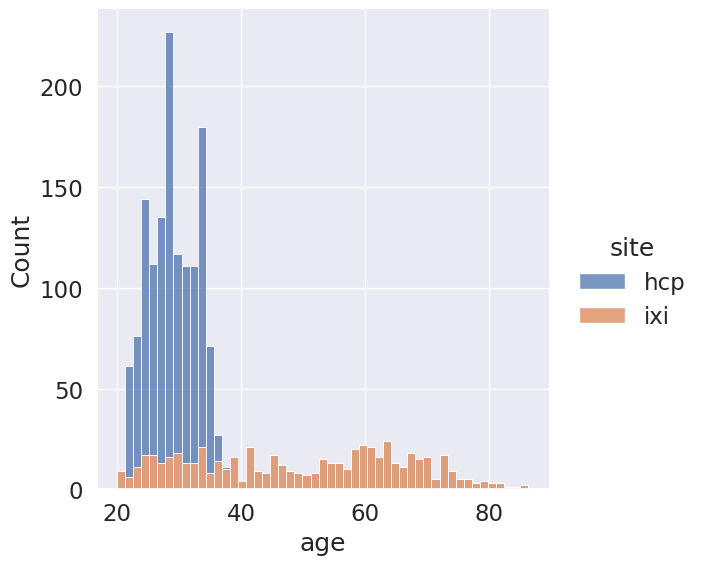

In [189]:
sns.displot(cov, x="age", hue="site", multiple="stack", height=6);

In [190]:
cov.groupby(['site']).describe()

age                                                                                sex                                             
       count       mean        std        min        25%       50%        75%       max   count      mean       std  min  25%  50%  75%  max
site                                                                                                                                        
hcp   1206.0  28.837479   3.690534  22.000000  26.000000  29.00000  32.000000  37.00000  1206.0  1.543947  0.498272  1.0  1.0  2.0  2.0  2.0
ixi    590.0  49.476531  16.720864  19.980835  34.027721  50.61191  63.413415  86.31896   590.0  1.555932  0.497283  1.0  1.0  2.0  2.0  2.0

## Preprare brain data

### Step 3.

Next, format and combine the MRI data using the following commands. The example data contains cortical thickness maps estimated by running recon-all from Freesurfer (version 6.0). The dimensionality of the data was reduced by using ROIs from the Desikan-Killiany atlas. Including the Euler number as a covariate is also recommended, as this is a proxy metric for data quality. The [Euler number](https://mathworld.wolfram.com/EulerCharacteristic.html) from each subject's recon-all output folder was extracted into a text file and is merged into the cortical thickness data frame. The Euler number is site-specific, thus, to use the same exclusion threshold across sites it is important to center the site by subtracting the site median from all subjects at a site. Then take the square root and multiply by negative one and exclude any subjects with a square root above 10.

Here is some psuedo-code (run from a terminal in the folder that has all subject's recon-all output folders) that was used to extract these ROIs:

```export SUBJECTS_DIR=/path/to/study/freesurfer_data/```

```aparcstats2table --subject sub-* --hemi lh --meas thickness --tablefile HCP1200_aparc_lh_thickness.txt```

```aparcstats2table --subject sub-* --hemi rh --meas thickness --tablefile HCP1200_aparc_rh_thickness.txt```

In [191]:
hcpya = pd.read_csv(os.path.join(wdir,'data','HCP1200_aparc_thickness.csv'))
ixi = pd.read_csv(os.path.join(wdir,'data','IXI_aparc_thickness.csv'))

In [192]:
brain_all = pd.merge(ixi, hcpya, how='outer')

We extracted the euler number from each subject's recon-all output folder into a text file and we now need to format and combine these into our brain dataframe.

Below is psuedo code for how we extracted the euler number from the recon-all.log for each subject. Run this from the terminal in the folder where your subjects recon-all output folders are located. This assumes that all of your subject IDs start with "sub-" prefix.

```for i in sub-*; do if [[ -e ${i}/scripts/recon-all.log ]]; then cat ${i}/scripts/recon-all.log | grep -A 1 "Computing euler" > temp_log; lh_en=`cat temp_log | head -2 | tail -1 | awk -F '=' '{print $2}' | awk -F ',' '{print $1}'`; rh_en=`cat temp_log | head -2 | tail -1 | awk -F '=' '{print $3}'`; echo "${i}, ${lh_en}, ${rh_en}" >> euler.csv; echo ${i}; fi; done```

In [193]:
hcp_euler = pd.read_csv(os.path.join(wdir,'data','hcp-ya_euler.csv'))
ixi_euler = pd.read_csv(os.path.join(wdir,'data','ixi_euler.csv'))

In [194]:
hcp_euler['site'] = 'hcp'
ixi_euler['site'] = 'ixi'

In [195]:
hcp_euler.replace(r'^\s*$', np.nan, regex=True, inplace=True)
ixi_euler.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [196]:
hcp_euler.dropna(inplace=True)
ixi_euler.dropna(inplace=True)

In [197]:
hcp_euler['rh_euler'] = hcp_euler['rh_euler'].astype(int)
hcp_euler['lh_euler'] = hcp_euler['lh_euler'].astype(int)
ixi_euler['rh_euler'] = ixi_euler['rh_euler'].astype(int)
ixi_euler['lh_euler'] = ixi_euler['lh_euler'].astype(int)

In [198]:
df_euler = pd.merge(hcp_euler, ixi_euler, on=['participant_id', 'lh_euler', 'rh_euler', 'site'], how='outer')

Finally, we need to center the euler number for each site. The euler number is very site-specific so in order to use the same exclusion threshold across sites we need to center the site by subtracting the site median from all subjects at a site. Then we will take the square root and multiply by negative one and exclude any subjects with a square root above 10. This choice of threshold is fairly random. If possible all of your data should be visually inspected to verify that the data inclusion is not too strict or too lenient.

In [199]:
df_euler['avg_euler'] = df_euler[['lh_euler','rh_euler']].mean(axis=1)

In [200]:
df_euler.groupby(by='site').median(numeric_only=True)

,lh_euler,rh_euler,avg_euler
site,,,
hcp,-44.0,-44.0,-43.0
ixi,-58.0,-54.0,-56.0


In [201]:
df_euler['site_median'] = df_euler['site']

In [202]:
df_euler['site_median'] = df_euler['site_median'].replace({'hcp':-43,'ixi':-56})

/tmp/ipython-input-2211394117.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_euler['site_median'] = df_euler['site_median'].replace({'hcp':-43,'ixi':-56})


In [203]:
df_euler['avg_euler_centered'] = df_euler['avg_euler'] - df_euler['site_median']

In [204]:
df_euler['avg_euler_centered_neg'] = df_euler['avg_euler_centered']*-1

In [205]:
df_euler['avg_euler_centered_neg_sqrt'] = np.sqrt(np.absolute(df_euler['avg_euler_centered_neg']))

In [206]:
brain = pd.merge(df_euler, brain_all, on=['participant_id'], how='inner')

In [207]:
brain_good = brain.query('avg_euler_centered_neg_sqrt < 10')

**CRITICAL STEP:** If possible, data should be visually inspected to verify that the data inclusion is not too strict or too lenient. Subjects above the Euler number threshold should be manually checked to verify and justify their exclusion due to poor data quality. This is just one approach for automated QC used by the developers of the PCNtoolkit. Other approaches such as the ENIGMA QC pipeline or UK Biobank’s QC pipeline are also viable options for automated QC.

## Combine covariate & cortical thickness dataframes

### Step 4.

The normative modeling function requires the covariate predictors and brain features to be in separate text files. However, it is important to first (inner) merge them together, using the following commands, to confirm that the same subjects are in each file and that the rows (representing subjects) align. This requires that both data frames have ‘subject_id’ as a column name. Once this is confirmed, exclude rows with NaN values and separate the brain features and covariate predictors into their own dataframes, using the commands below.

In [208]:
# make sure to use how="inner" so that we only include subjects that have data in both the covariate and the cortical thickness files
all_data = pd.merge(brain_good, cov, how='inner')

In [209]:
# Create a list of all the ROIs you want to run a normative model for (add additional names to this list if you would like to include other brain regions from the Desikan-Killian atlas)
roi_ids = ['lh_MeanThickness_thickness',
           'rh_MeanThickness_thickness',
           'lh_bankssts_thickness',
           'lh_caudalanteriorcingulate_thickness',
           'lh_superiorfrontal_thickness',
           'rh_superiorfrontal_thickness']

In [210]:
# Remove any subjects that have NaN variables in any of the columns
all_data.dropna(subset=roi_ids, inplace=True)

In [211]:
all_data_features = all_data[roi_ids]

In [212]:
all_data_covariates = all_data[['age','sex','site']]

**CRITICAL STEP:** `roi_ids` is a variable that represents which brain areas will be modeled and can be used to select subsets of the data frame if you do not wish to run models for the whole brain.

## Add variable to model site/scanner effects

### Step 5.

Currently, the different sites are coded in a single column (named ‘site’) and are represented as a string data type. However, the PCNtoolkit requires binary variables. Use the pandas package as follows to address this, which has a built-in function, `pd.get_dummies`, that takes in the string ‘site’ column and dummy encodes the site variable so that there is now a column for each site and the columns contain binary variables (0=not in this site, 1=present in this site).

In [213]:
all_data_covariates = pd.get_dummies(all_data_covariates, columns=['site'])

In [214]:
all_data['Average_Thickness'] = all_data[['lh_MeanThickness_thickness','rh_MeanThickness_thickness']].mean(axis=1)

## Train/test split

### Step 6.

In this example, we use 80% of the data for training and 20% for testing. Please carefully read the experimental design section on train/test split considerations when using your own data in this step. Using a function from scikit-learn (`train_test_split`), stratify the train/test split using the site variable to make sure that the train/test sets both contain data from all sites, using the following commands. Next, confirm that your train and test arrays are the same size (rows), using the following commands. You do not need the same size columns (subjects) in the train and test arrays, but the rows represent the covariate and responses which should be the same across train and test arrays.

In [215]:
all_data_covariates

,age,sex,site_hcp,site_ixi
0,27.000000,1,True,False
1,27.000000,2,True,False
2,33.000000,1,True,False
3,27.000000,1,True,False
4,35.000000,2,True,False
...,...,...,...,...
1687,47.723477,1,False,True
1688,50.395619,1,False,True
1689,42.989733,1,False,True
1690,46.220397,1,False,True


In [216]:
X_train, X_test, y_train, y_test = train_test_split(all_data_covariates.astype(float), all_data_features.astype(float), stratify=all_data['site'], test_size=0.2, random_state=42)

Verify that your train & test arrays are the same size

In [217]:
tr_cov_size = X_train.shape
tr_resp_size = y_train.shape
te_cov_size = X_test.shape
te_resp_size = y_test.shape
print("Train covariate size is: ", tr_cov_size)
print("Test covariate size is: ", te_cov_size)
print("Train response size is: ", tr_resp_size)
print("Test response size is: ", te_resp_size)

Train covariate size is:  (1353, 4)
Test covariate size is:  (339, 4)
Train response size is:  (1353, 6)
Test response size is:  (339, 6)


**CRITICAL STEP:** The model would not learn the site effects if all the data from one site was only in the test set. Therefore, we stratify the train/test split using the site variable.

### Step 7.

When the data were split into train and test sets, the row index was not reset. This means that the row index in the train and test data frames still correspond to the full data frame (before splitting the data occurred). The test set row index informs which subjects belong to which site, and this information is needed to evaluate per site performance metrics. Resetting the row index of the train/test data frames fixes this issue. Then extract the site row indices to a list (one list per site) and create a list called `site_names` that is used to decide which sites to evaluate model performance for, as follows:

In [218]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [219]:
# Get indices of all the subejcts in each site so that we can evaluate the test set metrics per site
hcp_idx = X_test.index[X_test['site_hcp'] == 1].to_list()
ixi_idx = X_test.index[X_test['site_ixi'] == 1].to_list()

In [220]:
# Save the site indices into a single list
sites = [hcp_idx, ixi_idx]

In [221]:
# Create a list with sites names to use in evaluating per-site metrics
site_names = ['hcp', 'ixi']

## Setup output directories

## Step 8.

Save each brain region to its own text file (organized in separate directories) using the following commands, because for each response variable, Y (e.g., brain region) we fit a separate normative model.

In [222]:
for c in y_train.columns:
    y_train[c].to_csv('resp_tr_' + c + '.txt', header=False, index=False)

In [223]:
X_train.to_csv('cov_tr.txt', sep = '\t', header=False, index = False)

In [224]:
y_train.to_csv('resp_tr.txt', sep = '\t', header=False, index = False)

In [225]:
for c in y_test.columns:
    y_test[c].to_csv('resp_te_' + c + '.txt', header=False, index=False)

In [226]:
X_test.to_csv('cov_te.txt', sep = '\t', header=False, index = False)

In [227]:
y_test.to_csv('resp_te.txt', sep = '\t', header=False, index = False)

In [228]:
! if [[ ! -e ROI_models/ ]]; then mkdir ROI_models; fi

In [229]:
# Note: please change the path in the following to wdir (depending on whether you are running on colab or not)

! for i in `cat /content/PCNtoolkit-demo/data/roi_dir_names`; do if [[ -e resp_tr_${i}.txt ]]; then cd ROI_models; mkdir ${i}; cd ../; cp resp_tr_${i}.txt ROI_models/${i}/resp_tr.txt; cp resp_te_${i}.txt ROI_models/${i}/resp_te.txt; cp cov_tr.txt ROI_models/${i}/cov_tr.txt; cp cov_te.txt ROI_models/${i}/cov_te.txt; fi; done

mkdir: cannot create directory ‘lh_MeanThickness_thickness’: File exists
mkdir: cannot create directory ‘lh_bankssts_thickness’: File exists
mkdir: cannot create directory ‘lh_caudalanteriorcingulate_thickness’: File exists
mkdir: cannot create directory ‘lh_superiorfrontal_thickness’: File exists
mkdir: cannot create directory ‘rh_MeanThickness_thickness’: File exists
mkdir: cannot create directory ‘rh_superiorfrontal_thickness’: File exists


In [230]:
# clean up files
! rm resp_*.txt

In [231]:
# clean up files
! rm cov_t*.txt

# Algorithm & Modeling

## Basis expansion using B-Splines

### Step 9.

Now, set up a B-spline basis set that allows us to perform nonlinear regression using a linear model, using the following commands. This basis is deliberately chosen to not to be too flexible so that it can only model relatively slowly varying trends. To increase the flexibility of the model you can change the parameterization (e.g., by adding knot points to the B-spline basis or increasing the order of the interpolating polynomial). Note that in the neuroimaging literature, it is more common to use a polynomial basis expansion for this. Piecewise polynomials like B-splines are superior to polynomial basis expansions because they do not introduce a global curvature. For further details on the use of B-splines see [Fraza et al](https://pubmed.ncbi.nlm.nih.gov/34798518/).

In [232]:
# set this path to wherever your ROI_models folder is located (where you copied all of the covariate & response text files to in Step 4)
data_dir = os.path.join(wdir, "tutorials", "BLR_protocol", "ROI_models")

# Create a cubic B-spline basis (used for regression)
xmin = 10#16 # xmin & xmax are the boundaries for ages of participants in the dataset
xmax = 95#90
B = create_bspline_basis(xmin, xmax)
# create the basis expansion for the covariates for each of the
for roi in roi_ids:
    print('Creating basis expansion for ROI:', roi)
    roi_dir = os.path.join(data_dir, roi)
    os.chdir(roi_dir)
    # create output dir
    os.makedirs(os.path.join(roi_dir,'blr'), exist_ok=True)
    # load train & test covariate data matrices
    X_tr = np.genfromtxt(os.path.join(roi_dir, 'cov_tr.txt'))
    X_te = np.genfromtxt(os.path.join(roi_dir, 'cov_te.txt'))
    # add intercept column
    X_tr = np.concatenate((X_tr, np.ones((X_tr.shape[0],1))), axis=1)
    X_te = np.concatenate((X_te, np.ones((X_te.shape[0],1))), axis=1)
    np.savetxt(os.path.join(roi_dir, 'cov_int_tr.txt'), X_tr)
    np.savetxt(os.path.join(roi_dir, 'cov_int_te.txt'), X_te)

    # create Bspline basis set
    Phi = np.array([B(i) for i in X_tr[:,0]])
    Phis = np.array([B(i) for i in X_te[:,0]])
    X_tr = np.concatenate((X_tr, Phi), axis=1)
    X_te = np.concatenate((X_te, Phis), axis=1)
    np.savetxt(os.path.join(roi_dir, 'cov_bspline_tr.txt'), X_tr)
    np.savetxt(os.path.join(roi_dir, 'cov_bspline_te.txt'), X_te)

Creating basis expansion for ROI: lh_MeanThickness_thickness
Creating basis expansion for ROI: rh_MeanThickness_thickness
Creating basis expansion for ROI: lh_bankssts_thickness
Creating basis expansion for ROI: lh_caudalanteriorcingulate_thickness
Creating basis expansion for ROI: lh_superiorfrontal_thickness
Creating basis expansion for ROI: rh_superiorfrontal_thickness


## Estimate normative model

### Step 10.

Set up a variable (`data_dir`) that specifies the path to the ROI directories that were created in Step 7. Initiate two empty pandas data frames where the evaluation metrics are the column names, as follows; one will be used for overall test set evaluation (`blr_metrics`) and one will be used for site-specific test set evaluation (`blr_site_metrics`). After the normative model has been estimated, these data frames will be saved as individual csv files.

In [233]:
# Create pandas dataframes with header names to save out the overall and per-site model evaluation metrics
blr_metrics = pd.DataFrame(columns = ['ROI', 'MSLL', 'EV', 'SMSE', 'RMSE', 'Rho'])
blr_site_metrics = pd.DataFrame(columns = ['ROI', 'site', 'MSLL', 'EV', 'SMSE', 'RMSE', 'Rho'])

### Step 11.

Estimate the normative models using a for loop to iterate over brain regions. An important consideration is whether to re-scale or standardize the covariates or responses. Whilst this generally only has a minor effect on the final model accuracy, it has implications for the interpretation of models and how they are configured. If the covariates and responses are both standardized (`standardize = True`), the model will return standardized coefficients. If (as in this case) the response variables are not standardized (`standardized = False`), then the scaling both covariates and responses will be reflected in the estimated coefficients. Also, under the linear modeling approach employed here, if the coefficients are unstandardized and do not have a zero mean, it is necessary to add an intercept column to the design matrix (this is done above in step 9 (B-spline)). The estimate function uses a few specific arguments that are worthy of commenting on:

    - alg = 'blr': specifies we should use Bayesian Linear Regression.  
    - optimizer = 'powell': use Powell's derivative-free optimization method (faster in this case than L-BFGS)
    - savemodel = False: do not write out the final estimated model to disk
    - saveoutput = False: return the outputs directly rather than writing them to disk
    - standardize = False: Do not standardize the covariates or response variables

**CRITICAL STEP:** This code fragment will loop through each region of interest in the `roi_ids` list (created in step 4) using Bayesian Linear Regression and evaluate the model on the independent test set. In principle, we could estimate the normative models on the whole data matrix at once (e.g., with the response variables stored in a `n_subjects` by `n_brain_measures` NumPy array or a text file instead of saved out into separate directories). However, running the models iteratively gives some extra flexibility in that it does not require that the included subjects are the same for each of the brain measures.

In [236]:
# Loop through ROIs
for roi in roi_ids:
    print('Running ROI:', roi)
    roi_dir = os.path.join(data_dir, roi)
    os.chdir(roi_dir)

    # configure the covariates to use. Change *_bspline_* to *_int_* to
    cov_file_tr = os.path.join(roi_dir, 'cov_bspline_tr.txt')
    cov_file_te = os.path.join(roi_dir, 'cov_bspline_te.txt')

    # load train & test response files
    resp_file_tr = os.path.join(roi_dir, 'resp_tr.txt')
    resp_file_te = os.path.join(roi_dir, 'resp_te.txt')

    # run a basic model
    yhat_te, s2_te, nm, Z, metrics_te = estimate(cov_file_tr,
                                                 resp_file_tr,
                                                 testresp=resp_file_te,
                                                 testcov=cov_file_te,
                                                 alg = 'blr',
                                                 optimizer = 'powell',
                                                 savemodel = True,
                                                 saveoutput = False,
                                                 standardize = False)
    # save metrics
    blr_metrics.loc[len(blr_metrics)] = [roi, metrics_te['MSLL'][0], metrics_te['EXPV'][0], metrics_te['SMSE'][0], metrics_te['RMSE'][0], metrics_te['Rho'][0]]

    # Compute metrics per site in test set, save to pandas df
    # load true test data
    X_te = np.loadtxt(cov_file_te)
    y_te = np.loadtxt(resp_file_te)
    y_te = y_te[:, np.newaxis] # make sure it is a 2-d array

    # load training data (required to compute the MSLL)
    y_tr = np.loadtxt(resp_file_tr)
    y_tr = y_tr[:, np.newaxis]

    for num, site in enumerate(sites):
        y_mean_te_site = np.array([[np.mean(y_te[site])]])
        y_var_te_site = np.array([[np.var(y_te[site])]])
        yhat_mean_te_site = np.array([[np.mean(yhat_te[site])]])
        yhat_var_te_site = np.array([[np.var(yhat_te[site])]])

        metrics_te_site = evaluate(y_te[site], yhat_te[site], s2_te[site], y_mean_te_site, y_var_te_site)

        site_name = site_names[num]
        blr_site_metrics.loc[len(blr_site_metrics)] = [roi, site_names[num], metrics_te_site['MSLL'][0], metrics_te_site['EXPV'][0], metrics_te_site['SMSE'][0], metrics_te_site['RMSE'][0], metrics_te_site['Rho'][0]]

Running ROI: lh_MeanThickness_thickness
inscaler: None
outscaler: None
Processing data in /content/PCNtoolkit-demo/tutorials/BLR_protocol/ROI_models/lh_MeanThickness_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1162.792820
         Iterations: 2
         Function evaluations: 43
Saving model meta-data...
Evaluating the model ...
Running ROI: rh_MeanThickness_thickness
inscaler: None
outscaler: None
Processing data in /content/PCNtoolkit-demo/tutorials/BLR_protocol/ROI_models/rh_MeanThickness_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -1187.621858
         Iterations: 2
         Function evaluations: 43
Saving model meta-data...
Evaluating the model ...
Running ROI: lh_bankssts_thickness
inscaler: None
outscaler: None
Processi

/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.15485e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=7.28434e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Optimization terminated successfully.
         Current function value: -578.945257
         Iterations: 2
         Function evaluations: 50
Saving model meta-data...
Evaluating the model ...
Running ROI: lh_caudalanteriorcingulate_thickness
inscaler: None
outscaler: None
Processing data in /content/PCNtoolkit-demo/tutorials/BLR_protocol/ROI_models/lh_caudalanteriorcingulate_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -235.509099
         Iterations: 3
         Function evaluations: 77
Saving model meta-data...
Evaluating the model ...
Running ROI: lh_superiorfrontal_thickness
inscaler: None
outscaler: None
Processing data in /content/PCNtoolkit-demo/tutorials/BLR_protocol/ROI_models/lh_superiorfrontal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Curre

# Evaluation & Interpretation

## Describe the normative model performance

### Step 12.

In step 11, when we looped over each region of interest in the `roi_ids` list (created in step 4) and evaluated the normative model on the independent test set, it also computed the evaluation metrics such as the explained variance, mean standardized log-loss and Pearson correlation between true and predicted test responses. The evaluation metrics were calculated for the full test set and calculated separately for each scanning site. The metrics were saved out to a csv file. In this step we load the evaluation metrics into a panads data frame and use the describe function to show the range, mean, and standard deviation of each of the evaluation metrics. Table 2 shows how to interpret the ranges/directions of good model fit.

In [237]:
# Overall test set evaluation metrics
print(blr_metrics['EV'].describe())
print(blr_metrics['MSLL'].describe())
print(blr_metrics['SMSE'].describe())
print(blr_metrics['Rho'].describe())

count    6.000000
mean     0.216747
std      0.114371
min      0.063284
25%      0.161901
50%      0.204015
75%      0.264058
max      0.397232
Name: EV, dtype: float64
count    6.000000
mean    -0.131996
std      0.080019
min     -0.267055
25%     -0.157321
50%     -0.120775
75%     -0.089765
max     -0.034441
Name: MSLL, dtype: float64
count    6.000000
mean     0.784798
std      0.114679
min      0.603410
25%      0.736912
50%      0.798426
75%      0.841000
max      0.936928
Name: SMSE, dtype: float64
count    6.000000
mean     0.452088
std      0.126840
min      0.257838
25%      0.403631
50%      0.450319
75%      0.513867
max      0.630935
Name: Rho, dtype: float64


The deviation scores are output as a text file in separate folders. We want to summarize the deviation scores across all models estimates so we can organize them into a single file, and merge the deviation scores into the original data file.

## Visualize normative model outputs

<div>
<img src="https://github.com/predictive-clinical-neuroscience/PCNtoolkit-demo/blob/main/tutorials/BLR_protocol/Figure4.png?raw=1" width="1000">
</div>

### Figure 4A viz

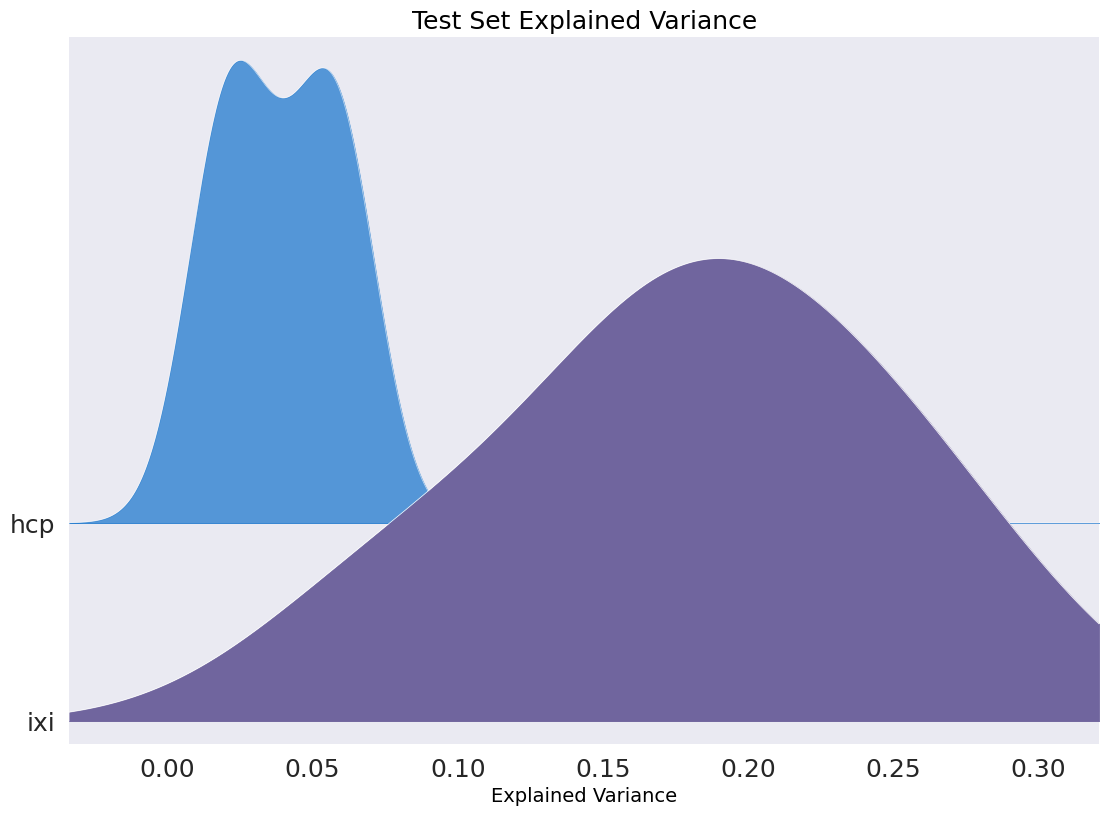

In [248]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

def color_gradient(x=0.0, start=(0, 0, 0), stop=(1, 1, 1)):
    r = np.interp(x, [0, 1], [start[0], stop[0]])
    g = np.interp(x, [0, 1], [start[1], stop[1]])
    b = np.interp(x, [0, 1], [start[2], stop[2]])
    return r, g, b

fig, axes = joypy.joyplot(blr_site_metrics, column=['EV'], overlap=2.5, by="site", ylim='own', fill=True, figsize=(8,8)
                          , legend=False, xlabels=True, ylabels=True, colormap=lambda x: color_gradient(x, start=(.08, .45, .8),stop=(.8, .34, .44))
                          , alpha=0.6, linewidth=.5, linecolor='w', fade=True)
fig.set_size_inches(12, 8)
plt.title('Test Set Explained Variance', fontsize=18, color='black', alpha=1)
plt.xlabel('Explained Variance', fontsize=14, color='black', alpha=1)
plt.ylabel('Site', fontsize=14, color='black', alpha=1)
plt.show()

The code used to create the visualizations shown in Figure 4 panels B-F, can be found in this [notebook](https://github.com/predictive-clinical-neuroscience/PCNtoolkit-demo/blob/main/tutorials/BLR_protocol/visualizations.ipynb).

## Post-Hoc analysis ideas

The code for running SVM classification and classical case vs. control t-testing on the outputs of normative modeling can be found in this [notebook](https://github.com/predictive-clinical-neuroscience/PCNtoolkit-demo/blob/main/tutorials/BLR_protocol/post_hoc_analysis.ipynb).

The code for running other predictive models (regression, using the outputs of normative modeling as predictive features) can be found in this [notebook](https://github.com/predictive-clinical-neuroscience/PCNtoolkit-demo/blob/main/tutorials/BLR_protocol/other_predictive_models.ipynb).

The code for transfering a pre-trained normative model to a new dataset can be found in this [notebook](https://github.com/predictive-clinical-neuroscience/PCNtoolkit-demo/blob/main/tutorials/BLR_protocol/transfer_pretrained_normative_models.ipynb).